In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import os,sys
import sqlite3
from os.path import join
from sklearn import feature_extraction
from nltk.stem.snowball import SnowballStemmer
from scipy.stats import itemfreq
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.externals import joblib
from scipy.sparse import csr_matrix
from tqdm import tqdm

### Get data
The data is all the news from visir.is, the urls to them are kept in the file urls_visir_dec18.txt.
We visit all the urls, which are about 280,000 and save the text. This runs pretty slowly on windows in notebook, but try running the file get_data.py to make this happen faster.

In [82]:
from multiprocessing import Pool
from multiprocessing import cpu_count
import urllib
from lxml.html import fromstring

urls = open("urls_visir_dec18.txt","r").read().split("\n")

def parse(i):
    url = urls[i]
    page = url.split('/')[-1]
    body = fromstring(urllib.request.urlopen(url).read())
    text = body.xpath("//*[contains(@class, 'article-single__content')]")[0].text_content().strip()
    header = body.xpath("//title")[0].text_content().strip()
    filename = join("article_texts",page)
    with open(filename+'.txt','w') as f:
        f.write(url+'\n')
        f.write(header)
        f.write('\n')
        f.write(text)
    print('Saved file %s' % filename)
    return i

if "linux" in sys.platform: #because multiprocessing doesn't work in jupyter on windows
    pool = Pool(4)
    for i in pool.imap_unordered(parse,range(len(urls))):
        continue
else:
    for i in tqdm(range(len(urls))):
        parse(i)



Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, 

Saved file article_texts/2010404343718
Saved file article_texts/2013130419377
5
6
Saved file article_texts/2011111129304
Saved file article_texts/2015150509104
Saved file article_texts/2016161229697
7
8
9
Saved file article_texts/2014140229372
Saved file article_texts/2014140309065
Saved file article_texts/2014140139991
Saved file article_texts/2014140229717
10
11
12
Saved file article_texts/2017171018911
Saved file article_texts/2016160909304
Saved file article_texts/2005505130363
13
14
4
15
Saved file article_texts/2018180729487
Saved file article_texts/2014140318603
Saved file article_texts/2017170929619
Saved file article_texts/2012120809020
16
17
18
19
Saved file article_texts/2005503150347
Saved file article_texts/2008978405078
Saved file article_texts/200880119056
Saved file article_texts/2005505040366
20
21
22
23
Saved file article_texts/2013130419369
Saved file article_texts/2011707049989
Saved file article_texts/2015150929125
Saved file article_texts/2009161283426
24
25
26
27

194
195
196
Saved file article_texts/2012120529767
Saved file article_texts/2016160419226
197
198
199
Saved file article_texts/200880326025
Saved file article_texts/2010751175735
200
201
Saved file article_texts/2017170409031
Saved file article_texts/2010584203234
Saved file article_texts/200770129101
203
202
204
Saved file article_texts/2011110919098
Saved file article_texts/200960820223
Saved file article_texts/200880228058
Saved file article_texts/2014140219618
207
206
208
205
Saved file article_texts/2010145165294
Saved file article_texts/2008615886638
Saved file article_texts/200770913037


Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:


209
210
211


Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiproc

KeyboardInterrupt: 

  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/socket.py", line 586, in readinto
    return self._sock.recv_into(b)
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
KeyboardInterrupt
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/urllib/request.py", line 1346, in http_open
    return self.do_open(http.client.HTTPConnection, req)
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/urllib/request.py", line 1346, in http_open
    return self.do_open(http.client.HTTPConnection, req)
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/urllib/request.py", line 1346, in http_open
    return self.do_open(http.client.HTTPConnection, req)
  File "/home/svpa/miniconda3

Saved file article_texts/2004410260334
Saved file article_texts/2013130219456
Saved file article_texts/2011565791321
Saved file article_texts/2015150628921
Saved file article_texts/2016160639878
Saved file article_texts/2013704239955
Saved file article_texts/2016160209288
Saved file article_texts/2018180129949
Saved file article_texts/2011710209991
Saved file article_texts/2015704229993
Saved file article_texts/2013710079973
Saved file article_texts/2016160319564
Saved file article_texts/2012120729728
Saved file article_texts/2011110339955
Saved file article_texts/201161034892
Saved file article_texts/2012121129717
Saved file article_texts/2011110929712
Saved file article_texts/2018180218985
Saved file article_texts/2017170829613
Saved file article_texts/2017170629441
Saved file article_texts/2018180529584
Saved file article_texts/2017170319616
Saved file article_texts/2012120819098
Saved file article_texts/2011110418838
Saved file article_texts/2013130509359
Saved file article_texts/2

Process ForkPoolWorker-9:
Process ForkPoolWorker-10:
Traceback (most recent call last):
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-82-fcd9b46e2068>", line 10, in parse
    body = fromstring(urllib.request.urlopen(url).read())
  File "/home/svpa/miniconda3/envs/py3/lib/python3.6/multiprocessing/pool.py", line 119, 

Now we should have a folder named article_texts containing one .txt file for each url. We now read them all and create a .csv file. Then you can just delete the article_texts directory.

In [ ]:

path = 'article_texts/'
files = os.listdir(path)
texts = []
headlines = []
urls = []
for k in tqdm(range(len(files))):
    f = files[k]
    try:
        lines = [i.decode("latin-1") for i in open(join(path,f),'rb').readlines()]
    except:
        continue
    lines = [i for i in lines if i != '']
    headline = lines[1].replace('\n','').replace("- Vísir","").strip()
    if headline == "":
        continue
    urls.append(lines[0].strip())
    headlines.append(headline)
    text = ''
    for i in lines[2:]:
        text = text + " " + i.lower().replace('\n','').strip()
    texts.append(text)

df = pd.DataFrame()
df["url"] = urls
df["headline"] = headlines
df["text"] = texts
df.to_csv("visir_texts.csv")

Now we have all the data, let's build some models
The code is mostly taken from this tutorial http://brandonrose.org/clustering#Visualizing-document-clusters

In [2]:
csv_file = "visir_texts.csv" #load data

df = pd.read_csv(csv_file)
urls = df["url"]
headlines = df["header"]
texts = df["text"]

if not os.path.isdir("experiments"):
    os.mkdir("experiments")
if not os.path.isdir(join("experiments",csv_file.replace(".csv",""))):
    os.mkdir(join("experiments",csv_file.replace(".csv","")))

save_folder = join("experiments",csv_file.replace(".csv","")) #where we save all results and models

def tokenize(txt):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(txt)


def most_common_words(texts,n):
    tokenizer = RegexpTokenizer(r'\w+')
    word_lists = []
    for i in tqdm(range(len(texts))):
        word_lists.append(tokenizer.tokenize(texts[i]))
    words = [x for n in word_lists for x in n]
    wf = Counter(words).most_common()
    return wf

if os.path.isfile(join(save_folder,"most_common.npy")):
    mc = np.load(join(save_folder,"most_common.npy"))
else:
    print("Finding most common words...")
    mc = most_common_words(texts[:20000],10)
    mc = np.array(mc)
    np.save(join(save_folder,"most_common.npy"),mc)

    

Because the computations can take pretty long, we only do them the first time and save the models to disk, and after that we load the previously created models.

In [3]:
stop_words = mc[:20,0]
if os.path.isfile(join(save_folder,"vectorizer.pkl")):
    print("Loading tfidf matrix...")
    #tfidf_vectorizer = joblib.load(join(save_folder,"vectorizer.pkl"))
    tfidf_matrix = np.load(join(save_folder,"tfidf_matrix.npy"))
    terms = np.load(join(save_folder,"terms.npy"))
    try:
        tfidf_matrix = csr_matrix(tfidf_matrix.tolist()).todense()
    except:
        pass
else:
    print("Creating tfidf matrix...")
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                             min_df=0.01, stop_words = list(stop_words),
                             use_idf=True, tokenizer=tokenize, ngram_range=(1,3))
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
    np.save(join(save_folder,"tfidf_matrix.npy"),tfidf_matrix)
    joblib.dump(tfidf_vectorizer, join(save_folder,"vectorizer.pkl"))

Loading tfidf matrix...


In [4]:
n_clusters = 4

if os.path.isfile(join(save_folder,"km_%d_clusters.pkl"%n_clusters)):
    km = joblib.load(join(save_folder,"km_%d_clusters.pkl"%n_clusters))
    print("Loaded kmeans model")
else:
    print("Training kmeans model...")
    km = MiniBatchKMeans(n_clusters=n_clusters)
    km.fit(tfidf_matrix)

clusters = km.labels_.tolist()
df["cluster"] = clusters
order_centroids = km.cluster_centers_.argsort()[:, ::-1]


Loaded kmeans model


In [5]:
df["cluster"].value_counts()

0    141614
1     86450
2     28618
3     23608
Name: cluster, dtype: int64

In [6]:
print("Top terms per cluster:")
print()
for i in range(n_clusters):
    print("Cluster %d words:" % i, end='')

    for ind in order_centroids[i, :100]: #replace 6 with n words per cluster
        #if terms[ind] not in mc[0][:200]:
        print(' %s' % terms[ind], end=',')
    print() #add whitespace
    print() #add whitespace

    print("Cluster %d headlines:" % i, end='')
    for headline in df[df["cluster"]==i]['header'].values.tolist()[:20]:
        print(' %s,' % headline, end='')
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: gær, ára, einnig, árið, samkvæmt, morgun, hafði, kemur, klukkan, lögreglan, má, kom, hennar, maðurinn, áður, undir, gegn, málið, sjá, lögreglu, hefði, þúsund, honum, enn, tilkynningu, manns, annars, sinni, inn, íslands, síðan, einn, sína, landsins, síðustu, nótt, talið, fór, varð, trump, sinn, fimm, saman, komið, ræða, segja, bandaríkjanna, ári, fyrr, bandaríkjunum, stað, landinu, fyrrverandi, gærkvöldi, taka, auk, henni, muni, milli, þær, tók, kvöld, tveir, hvort, þann, aftur, forseti, gert, fyrsta, sex, fara, farið, tekið, ásamt, landi, síðasta, séu, lögregla, höfuðborgarsvæðinu, viku, forsætisráðherra, rannsókn, leið, frétt, sögn, new, niður, málinu, reykjavík, hana, 2, átti, daga, fer, áfram, borginni, norður, sá, bbc, sitt,

Cluster 0 headlines: KB banki ætlar í bíó, Réttað yfir Khodorkovsky, Gaumur vanmetinn í sameiningu, Lögsóttir fyrir ólöglega dreifingu, Vegleg 17. júní hátíð í ár, Börnin blogga, 27 á Íslandi, Fær bara brauð og vatn, Ra

/home/svpa/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


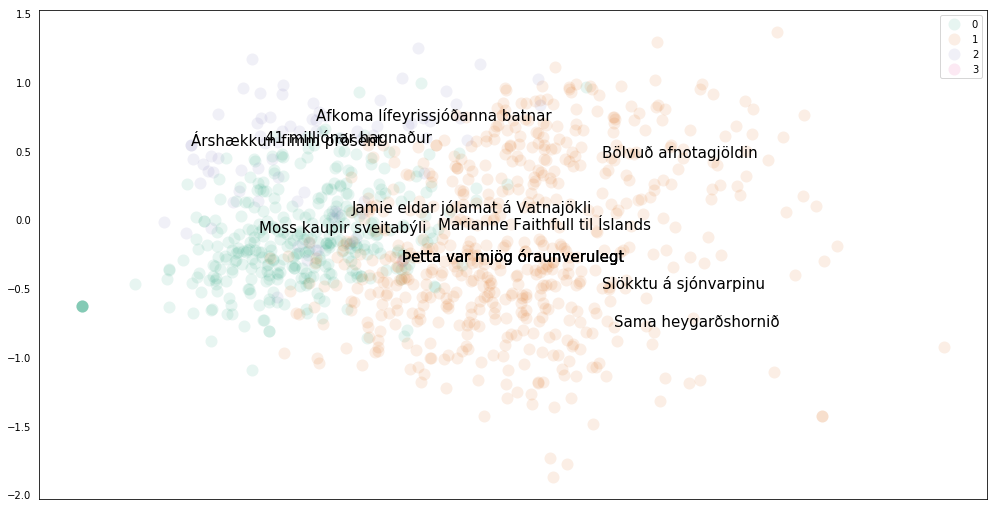

In [41]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA

%matplotlib inline 

if os.path.isfile(join(save_folder,"pca.pkl")):
    pca = joblib.load(join(save_folder,"pca.pkl"))
else:
    pca = PCA(n_components=2)
    pca.fit(1-cosine_similarity(tfidf_matrix[:5000]))
    joblib.dump(mds,join(save_folder,"pca.pkl"))
    
def get_2d_pos(documents):
    d = 1-cosine_similarity(tfidf_matrix[:5000],documents)
    xy = pca.transform(d.T)
    return xy[:,0],xy[:,1]
    

cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

n_samples = 1000

xs,ys = get_2d_pos(tfidf_matrix[:n_samples])
plot_df = pd.DataFrame(dict(x=xs, y=ys, cluster=clusters[:n_samples], headline=headlines[:n_samples])) 
groups = plot_df.groupby('cluster')


    
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=name, color=cluster_colors[name], 
            mec='none',alpha=0.1)
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',)         # ticks along the top edge are off

ax.legend(numpoints=1)  #show legend with only 1 point

for i in range(n_clusters):
    cluster_df = plot_df[plot_df["cluster"]==i].reset_index()
    for j in np.random.choice(np.arange(len(cluster_df)),3):
        ax.text(cluster_df.loc[j]['x'], cluster_df.loc[j]['y'], cluster_df.loc[j]['headline'], size=15)  